In [1]:
import d2l
from matplotlib import pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import torch
from torch import nn
import torchvision

import shared_loader
import shared_models

### Load image data

train_positive=25969
train_negative=38507
val_positive=11585
val_negative=7607
train=51938
val=15214


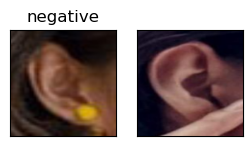

In [2]:
data = shared_loader.PairedEarData(batch_size=128)
batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

### Training loop

In [3]:
def accuracy(y_hat, y):
    # referenced the logistic regression notebook for this
    # then pytorch-ified it
    y_hat = torch.where(y_hat >= .5, 1, 0)
    return (y_hat == y).float().mean().cpu()

In [4]:
def model_training(model, data, optimizer, loss_fn, epochs = 10, early_stopping = True, verbose = True):
    # overall loss value for each epoch:
    loss_train = []
    loss_valid = []
    accuracy_valid = []

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25

    for epoch in range(epochs):
        if verbose and (epoch+1)%10 == 0:
            print("epoch", epoch + 1,)

        model.train()
        loss_values = [] # loss values for each batch
        for batch_X, batch_y in data.train_dataloader():
            (batch_X_1, batch_X_2) = batch_X
            batch_X_1, batch_X_2 = batch_X_1.to(device), batch_X_2.to(device)
            batch_y = batch_y.to(device)
            preds = model(batch_X_1, batch_X_2)
            # ugh this function expects float instead of int for comparison
            # otherwise the kernel CRASHES instead of giving a type error
            loss = loss_fn(preds, batch_y.unsqueeze(1).float())
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_train.append(np.mean(loss_values))

        model.eval()
        loss_values = []
        accuracy_values = []
        for batch_X, batch_y in data.val_dataloader():
            (batch_X_1, batch_X_2) = batch_X
            batch_X_1, batch_X_2 = batch_X_1.to(device), batch_X_2.to(device)
            batch_y = batch_y.to(device)
            with torch.no_grad():
                preds = model(batch_X_1, batch_X_2)
                #print(preds)
                loss = loss_fn(preds, batch_y.unsqueeze(1).float())
                loss_values.append(loss.item())
                accuracy_values.append(accuracy(preds, batch_y).item())

        if early_stopping:     
            val_loss = np.mean(loss_values)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save the best model weights here
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}.")
                    break
 
        loss_valid.append(np.mean(loss_values))
        accuracy_valid.append(np.mean(accuracy_values))
        if verbose and epoch%10 == 0:
            print(f"accuracy: {accuracy_valid[-1]:.8f}")

    return model, loss_train, loss_valid, accuracy_valid

### Baseline cnn

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device=}")

Using device='mps'


In [6]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [7]:
model = shared_models.PairCNN()
model.apply(init_cnn)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [8]:
model, loss_train, loss_valid, accuracy_valid = model_training(
    model, data, optimizer, loss_fn, epochs=20, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.50822687
epoch 10
accuracy: 0.53357286
epoch 20
accuracy: 0.5436866613997131


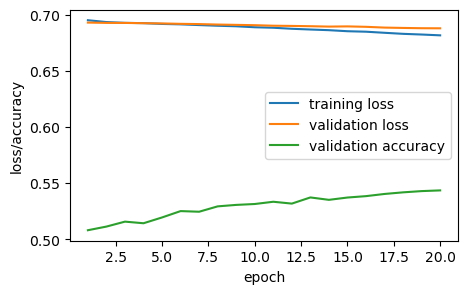

In [9]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

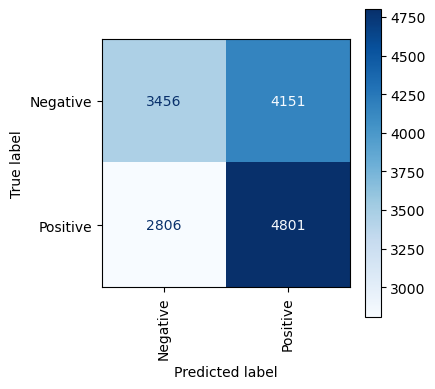

In [10]:
ys = []
preds = []

for batch_X, batch_y in data.val_dataloader():
    (batch_X_1, batch_X_2) = batch_X
    batch_X_1, batch_X_2 = batch_X_1.to(device), batch_X_2.to(device)
    batch_y = batch_y.to(device)

    y_pred = model(batch_X_1, batch_X_2)
    y_pred = (y_pred >= 0.5).long()
    y_pred = y_pred.detach().cpu().numpy()

    ys.extend(batch_y.cpu().numpy().tolist())
    preds.extend(y_pred.tolist())

matrix = confusion_matrix(ys, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical");

### Finetune ResNet-18

In [11]:
model = shared_models.PairResnet18()

nn.init.xavier_uniform_(model.fc.weight);
model = model.to(device)

learning_rate = 0.0001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

params_1x = [param for name, param in model.named_parameters() 
             if name not in ["fc.weight", "fc.bias"]]
optimizer = torch.optim.SGD([{'params': params_1x},
                             {'params': model.fc.parameters(),
                            'lr': learning_rate * 10}],
                            lr=learning_rate, weight_decay=0.001)

In [12]:
model, loss_train, loss_valid, accuracy_valid = model_training(
    model, data, optimizer, loss_fn, epochs=20, early_stopping=False, verbose=True
)
print(f"accuracy: {accuracy_valid[-1]}")

accuracy: 0.51546475
epoch 10
accuracy: 0.51748640
epoch 20
accuracy: 0.5157944249505756


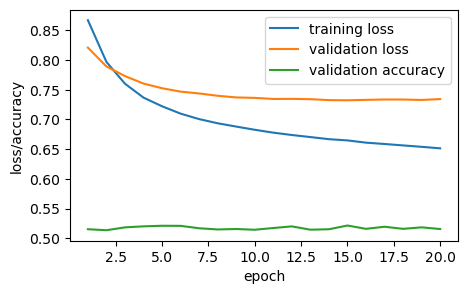

In [13]:
plt.figure(figsize=(5,3))
plt.plot(range(1, len(loss_train)+1), loss_train, label='training loss')
plt.plot(range(1, len(loss_valid)+1), loss_valid, label='validation loss')
plt.plot(range(1, len(loss_valid)+1), accuracy_valid, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend();

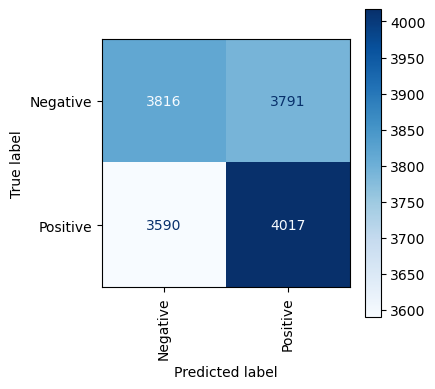

In [14]:
ys = []
preds = []

for batch_X, batch_y in data.val_dataloader():
    (batch_X_1, batch_X_2) = batch_X
    batch_X_1, batch_X_2 = batch_X_1.to(device), batch_X_2.to(device)
    batch_y = batch_y.to(device)

    y_pred = model(batch_X_1, batch_X_2)
    y_pred = (y_pred >= 0.5).long()
    y_pred = y_pred.detach().cpu().numpy()

    ys.extend(batch_y.cpu().numpy().tolist())
    preds.extend(y_pred.tolist())

matrix = confusion_matrix(ys, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical");